# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="Original-Data-1" href="#Original-Data"><span class="toc-item-num">1&nbsp;&nbsp;</span>Original Data</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Basic-Stats-2" href="#Basic-Stats"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Stats</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Description-of-Summary-Stats-File-2.1" href="#Description-of-Summary-Stats-File"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Description of Summary Stats File</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Exploring-roi1-2.2" href="#Exploring-roi1"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Exploring roi1</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Exploring-ccs2-2.3" href="#Exploring-ccs2"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Exploring ccs2</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Compare-roi1-and-ccs2-3" href="#Compare-roi1-and-ccs2"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compare roi1 and ccs2</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Compare-Number-of-Passes-with-Qualities-3.1" href="#Compare-Number-of-Passes-with-Qualities"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compare Number of Passes with Qualities</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Reads-with-Poly-A-4" href="#Reads-with-Poly-A"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reads with Poly-A</a></div>

In [1]:
# Load Jupyter Notebook Extensions
%reload_ext autoreload
%reload_ext ipycache
%autoreload 2

%config CacheMagics.cachedir='./cachedir'

In [2]:
# Imports
import os
import re
from operator import ne as ne
from itertools import product
import gzip
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML, IFrame

from Bio import SeqIO

In [3]:
# Set Display Options
## Pandas
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 999)

sns.set_context('poster')
## Matplotlib
%matplotlib inline

This notebook is taking an initial look at PacBio sequencing that we had done in June 2016. 

We submitted 4 samples (whole females, whole males, ovaries, testis) to the NIH PacBio Sequencing Core. This is an initial test run with only one replicate for each sample. Total RNA was given to the PacBio sequencing core and they generated polyA+ libraries.

Morgan (the sequencing centers bioinformaticist) sent this email regarding our current PacBio samples. Here he discusses naming schema and different files provided

```
...
The reads are in the 'Data_20160630' directory.

For each sample library, 3 size fractions were created and each individual library fraction was loaded/run separately to avoid loading bias.

size fractions:
ARL000*_1 = 1-2 kb
ARL000*_2 = 2-3 kb
ARL000*_3 = 3-6 kb

w1118_wfem1:
ARL0001_1
ARL0001_2
ARL0001_3

w1118_wmal1:
ARL0002_1
ARL0002_2
ARL0002_3

w1118_ovary1:
ARL0003_1
ARL0003_2
ARL0003_3

w1118_testi1:
ARL0004_1
ARL0004_2
ARL0004_3

Each library directory in Data_20160630 contains a subreads, roi1, ccs2 directory.

subreads = raw reads from the run; low accuracy reads (average accuracy 0.85, quality value 8) - filtered_subreads.fastq.gz

roi1 = circular consensus reads using current production software; higher accuracy reads; depending on number of passes, the reads can be > 0.999 accurate, > 30 quality value (see roi1_stats.txt file in each directory for statistics for each read) - roi1_stats.txt, reads_of_insert.fastq.gz

ccs2 = circular consensus reads using new development software that will be included in the next software release; improved algorithm; researchers have reported better results using ccs2 reads - ccs2_stats.txt, *.ccs.fastq.gz
...
```

Morgan provided processed data from the current stable version of the PacBio software (`roi1`) and from the development version of the software (`ccs2`). He reports that some people have found the `ccs2` version of the software performs better. I want to explore the basics summary stats for these two sets of processed data.

First I need to understand the steps of PacBio sequencing. There are a lot of very useful resources out there. Here is a record of some of the resources I have read.

* https://github.com/PacificBiosciences
* http://files.pacb.com/software/smrtanalysis/2.0.0/doc/smrtportal/help/Portal_PacBio_Glossary.htm
* http://seqanswers.com/forums/showthread.php?t=34790

There are also a lot of slides and talks out there. Here is a useful slide deck.

https://speakerdeck.com/pacbio/specifics-of-smrt-sequencing-data

In [28]:
# PacBio Slides
IFrame('https://speakerdeck.com/player/1de304607e0a01309b1b12313b032e6a?#', 1000, 800)

https://speakerdeck.com/pacbio/track-1-isoseq

In [26]:
# PacBio Slides
IFrame('https://speakerdeck.com/player/ceb4e1a04120013242c936dddb3f194a?#', 1000, 800)

Looking at the various resources I have the following useful definitions.

* **CCS:** Circular Concensus Sequencing

* **ROI:** Read of Interest

* **ZMW:** Zero-Mode Waveguide -- I am understanding this as a well on the chip. The ZMW should be single molecule, but sometimes multiple molecule/polymerases are in a single well (see slides).

* **Quality Value Assignment:** A prediction of the error probability of a basecall.

* **Quality Value (QV):** The total probability that the basecall is an insertion or substitution or is preceded by a deletion. (QV = -10 * log10(1-p) 

These are some example Quality Values and their relationship to accuracy from a PacBio presentation.
* QV = 10 ~90% accuracy.
* QV = 20 ~99% accuracy.
* QV = 50 ~99.999% accuracy.

# Original Data

In [4]:
# PacBio data is located on Biowulf at
data_dir = '../../data/Data_20160630'

In [5]:
# PacBio libraries were separted into 3 size groups
size_map = {
    "1": "1-2 kb",
    "2": "2-3 kb",
    "3": "3-6 kb"
}

# There were four samples which map to the following IDs
sample_map = {
    'w1118_wfem1': "ARL0001",
    'w1118_wmal1': "ARL0002",
    'w1118_ovary1': "ARL0003",
    'w1118_testi1': "ARL0004"
}

sex_map = {
    'w1118_wfem1': "female",
    'w1118_wmal1': "male",
    'w1118_ovary1': "female",
    'w1118_testi1': "male"
}

tissue_map = {
    'w1118_wfem1': "whole",
    'w1118_wmal1': "whole",
    'w1118_ovary1': "ovary",
    'w1118_testi1': "testis"
}

# Inverse sample map for easy look ups
sample_map_inverse = {v: k for k, v in sample_map.items()}

# Samples are name sampleID_sampleSizeGroup for example ARL0001_1
sampleNames = ['_'.join(x) for x in product(sample_map.values(), size_map.keys())]

Morgan provided the following files via Globus. The file structure is:

In [11]:
# File Tree
!tree $data_dir | head -n 19 && echo "..."

../../data/Data_20160630
├── ARL0001_1
│   ├── ccs2
│   │   ├── ARL0001_1_ccs2_stats.txt
│   │   └── m160606_202633_42231_c100988372550000001823222407191664_s1_p0.ccs.fastq.gz
│   ├── roi1
│   │   ├── ARL0001_1_roi1_stats.txt
│   │   └── reads_of_insert.fastq.gz
│   └── subreads
│       └── filtered_subreads.fastq.gz
├── ARL0001_2
│   ├── ccs2
│   │   ├── ARL0001_2_ccs2_stats.txt
│   │   └── m160608_202943_42231_c100988442550000001823222407191664_s1_p0.ccs.fastq.gz
│   ├── roi1
│   │   ├── ARL0001_2_roi1_stats.txt
│   │   └── reads_of_insert.fastq.gz
│   └── subreads
│       └── filtered_subreads.fastq.gz
...


In [18]:
# Build a sample Sable for other analysis
rows = []

def read_cnt(x):
    cnt = !gunzip -c ../../$x | sed -n "4~1p" | wc -l
    return '{:,}'.format(int(cnt[0]))


for sample, size in product(sample_map_inverse.keys(), size_map.keys()):
    sampleID = sample_map_inverse[sample]  # This is my sample ID
    sex = sex_map[sampleID]  # The sex of the sample male|female
    tissue = tissue_map[sampleID]  # The tissue of the sample ovary|testis|whole
    runID = 'Data_20160630'  # Run ID assigned by the core
    date = '2016-06-30'  # Date the core released the data
    processID = '_'.join([sample, size])  # ID assigned by the core, contains a sampleID and a sizeID (e.g. ARL0001_1)
    sizeBin = size_map[size]  # The size range 1-2kb|2-3kb|3-6kb
    subreads = 'data/{runID}/{processID}/subreads/filtered_subreads.fastq.gz'.format(runID=runID, processID=processID) # Subreads fq
    subread_cnt = read_cnt(subreads)
    roi1 = 'data/{runID}/{processID}/roi1/reads_of_insert.fastq.gz'.format(runID=runID, processID=processID)  # roi1 fq
    roi1_cnt = read_cnt(roi1)
    ccs2FileName = os.path.basename(glob('../../data/{runID}/{processID}/ccs2/*.fastq.gz'.format(runID=runID, processID=processID))[0])  # get fq name for ccs2 file
    ccs2 = 'data/{runID}/{processID}/ccs2/{fileName}'.format(runID=runID, processID=processID, fileName=ccs2FileName)  # ccs2 fq
    ccs2_cnt = read_cnt(ccs2)
    
    rows.append((sampleID, sex, tissue, runID, date, processID, sizeBin, subreads, subread_cnt, roi1, roi1_cnt, ccs2, ccs2_cnt))

sampleTable = pd.DataFrame(rows, columns=['sampleID', 'sex', 'tissue', 'runID', 'date', 'processID', 'sizeBin', 'subreads', 'num_subreads', 'roi1', 'num_roi1',  'ccs2', 'num_ccs2'])
sampleTable.sort_values('processID', inplace=True)
sampleTable.to_csv('../../config/pacbio_samples_20160620.csv', index=False)
display(sampleTable.set_index(['sampleID', 'processID']))

sex  tissue          runID        date sizeBin  \
sampleID     processID                                                      
w1118_wfem1  ARL0001_1  female   whole  Data_20160630  2016-06-30  1-2 kb   
             ARL0001_2  female   whole  Data_20160630  2016-06-30  2-3 kb   
             ARL0001_3  female   whole  Data_20160630  2016-06-30  3-6 kb   
w1118_wmal1  ARL0002_1    male   whole  Data_20160630  2016-06-30  1-2 kb   
             ARL0002_2    male   whole  Data_20160630  2016-06-30  2-3 kb   
             ARL0002_3    male   whole  Data_20160630  2016-06-30  3-6 kb   
w1118_ovary1 ARL0003_1  female   ovary  Data_20160630  2016-06-30  1-2 kb   
             ARL0003_2  female   ovary  Data_20160630  2016-06-30  2-3 kb   
             ARL0003_3  female   ovary  Data_20160630  2016-06-30  3-6 kb   
w1118_testi1 ARL0004_1    male  testis  Data_20160630  2016-06-30  1-2 kb   
             ARL0004_2    male  testis  Data_20160630  2016-06-30  2-3 kb   
             ARL0004_3    male  testis  Data_20160630  2016-06-30  3-6 kb   

                                                                 subreads  \
sampleID     processID                                                      
w1118_wfem1  ARL0001_1  data/Data_20160630/ARL0001_1/subreads/filtered...   
             ARL0001_2  data/Data_20160630/ARL0001_2/subreads/filtered...   
             ARL0001_3  data/Data_20160630/ARL0001_3/subreads/filtered...   
w1118_wmal1  ARL0002_1  data/Data_20160630/ARL0002_1/subreads/filtered...   
             ARL0002_2  data/Data_20160630/ARL0002_2/subreads/filtered...   
             ARL0002_3  data/Data_20160630/ARL0002_3/subreads/filtered...   
w1118_ovary1 ARL0003_1  data/Data_20160630/ARL0003_1/subreads/filtered...   
             ARL0003_2  data/Data_20160630/ARL0003_2/subreads/filtered...   
             ARL0003_3  data/Data_20160630/ARL0003_3/subreads/filtered...   
w1118_testi1 ARL0004_1  data/Data_20160630/ARL0004_1/subreads/filtered...   
             ARL0004_2  data/Data_20160630/ARL0004_2/subreads/filtered...   
             ARL0004_3  data/Data_20160630/ARL0004_3/subreads/filtered...   

                       num_subreads  \
sampleID     processID                
w1118_wfem1  ARL0001_1    4,237,457   
             ARL0001_2    3,217,741   
             ARL0001_3    2,273,317   
w1118_wmal1  ARL0002_1    3,568,705   
             ARL0002_2    3,294,325   
             ARL0002_3    2,719,805   
w1118_ovary1 ARL0003_1    3,544,853   
             ARL0003_2    3,038,281   
             ARL0003_3    2,545,413   
w1118_testi1 ARL0004_1    5,030,449   
             ARL0004_2    3,126,549   
             ARL0004_3    3,127,393   

                                                                     roi1  \
sampleID     processID                                                      
w1118_wfem1  ARL0001_1  data/Data_20160630/ARL0001_1/roi1/reads_of_ins...   
             ARL0001_2  data/Data_20160630/ARL0001_2/roi1/reads_of_ins...   
             ARL0001_3  data/Data_20160630/ARL0001_3/roi1/reads_of_ins...   
w1118_wmal1  ARL0002_1  data/Data_20160630/ARL0002_1/roi1/reads_of_ins...   
             ARL0002_2  data/Data_20160630/ARL0002_2/roi1/reads_of_ins...   
             ARL0002_3  data/Data_20160630/ARL0002_3/roi1/reads_of_ins...   
w1118_ovary1 ARL0003_1  data/Data_20160630/ARL0003_1/roi1/reads_of_ins...   
             ARL0003_2  data/Data_20160630/ARL0003_2/roi1/reads_of_ins...   
             ARL0003_3  data/Data_20160630/ARL0003_3/roi1/reads_of_ins...   
w1118_testi1 ARL0004_1  data/Data_20160630/ARL0004_1/roi1/reads_of_ins...   
             ARL0004_2  data/Data_20160630/ARL0004_2/roi1/reads_of_ins...   
             ARL0004_3  data/Data_20160630/ARL0004_3/roi1/reads_of_ins...   

                       num_roi1  \
sampleID     processID            
w1118_wfem1  ARL0001_1  192,401   
             ARL0001_2  218,457   
             ARL0001_3  188,373   
w1118_wmal1  ARL0002_1  175,341   
             ARL0002_2  246,789  

# Basic Stats

## Description of Summary Stats File

In the summary statistics file provided by Morgan, there are the following columns:
* `SEQUENCE_NAME`: This is just the read ID. 
* `LENGTH`: This is the length of the read.
* `NUM_PASSES`: This is the number of complete subreads used to make consensus.
* `MEAN_SCORE`: This is the average quality score at each base.
* `MEAN_QVAL`: This is the Quality value of the MEAN_SCORE (see equation below).

I could not find these specific definitions anywhere so now I just want to verify the values for a single read.

From the stats file:

```
/data/Oliverlab/fastq/PacBio/Data_20160630/ARL0001_1/ccs2/ARL0001_1_ccs2_stats.txt

SEQUENCE_NAME: m160606_202633_42231_c100988372550000001823222407191664_s1_p0/24/ccs    
LENGTH: 1893    
NUM_PASSES: 16      
MEAN_SCORE: 0.999856
MEAN_QVAL: 38
```

Now I compare these results with the first read of the CCS2 file:

```
/data/Oliverlab/fastq/PacBio/Data_20160630/ARL0001_1/ccs2/m160606_202633_42231_c100988372550000001823222407191664_s1_p0.ccs.fastq.gz
```

In [14]:
# Import single read
with gzip.open('../../data/Data_20160630/ARL0001_1/ccs2/m160606_202633_42231_c100988372550000001823222407191664_s1_p0.ccs.fastq.gz', 'rt', encoding='utf-8') as FH:
    header = FH.readline().rstrip()
    seq = FH.readline().rstrip()
    _ = FH.readline()
    score = FH.readline().rstrip()

In [15]:
# Compare header to the stats to make sure looking at the sample read
assert header == "@" + 'm160606_202633_42231_c100988372550000001823222407191664_s1_p0/24/ccs'
print("header:", header)

header: @m160606_202633_42231_c100988372550000001823222407191664_s1_p0/24/ccs


In [16]:
# Compare sequence lengths to make sure they are the same
assert len(seq) == 1893
print("sequence length:", len(seq))

sequence length: 1893


In [17]:
%%cache -s subread_count_for_specific_read.pkl num_pass
# Look in the subreads and see if the number of reads with the begining of the read ID matches the num_passes
query = header.rstrip('css')

# This takes a while so cached it
num_pass = !gunzip -c ../../data/Data_20160630/ARL0001_1/subreads/filtered_subreads.fastq.gz | grep $query | wc -l
print('There are {} subreads that begining with this read name.'.format(num_pass[0]))
print('From', '../../data/Data_20160630/ARL0001_1/subreads/filtered_subreads.fastq.gz')

There are 18 subreads that begining with this read name.
From ../../data/Data_20160630/ARL0001_1/subreads/filtered_subreads.fastq.gz


In [18]:
# print out the quality score
#print('The current reads quality scores are:\n\n', score)

# Get average quality score assuming phred 33
avgSeqQ = np.array([ord(x) - 33 for x in score]).mean()
print('Assuming a phred33 system, the average quality score for the read is:', avgSeqQ)

Assuming a phred33 system, the average quality score for the read is: 91.1030110935


The `NUM_PASSES` does not match the number of subreads, is this because of incomplete reads?

In [19]:
%%cache -s subreads_for_specific_read.pkl subreads
subreads = !gunzip -c ../../data/Data_20160630/ARL0001_1/subreads/filtered_subreads.fastq.gz | grep -A1 $query
print('Length of subreads:', [len(x) for x in subreads if not x.startswith('@') and not x.startswith('-')])

Length of subreads: [216, 1825, 1974, 1864, 1908, 1876, 1916, 1863, 1895, 1908, 1883, 1879, 1869, 1856, 1875, 1883, 1897, 1467]


My definitions are close. 

* `NUM_PASSES` is not exactly the number of subreads (16 vs 18), but two of the reads appear partial (216 and 1467 bp long). I am thinking the CCS processing does not count these as full reads, but it is hard to know without the original HDF5 file.

* `MAEN_SCORE` and `MEAN_QVAL` are also not exactly right. These values are related (see Quality Value definition below) so I am not sure which one to get from the data (or if I can get them from the data). 

## Exploring roi1

In [20]:
# Import all of the data files
def readRoi1CSVs(fnames):
    dfs = []
    for fn in fnames:
        df = pd.read_csv(os.path.join(data_dir, '{0}/roi1/{0}_roi1_stats.txt'.format(fn)), sep='\t', index_col=0)
        df['sampleID'] = fn
        df['sample'] = sample_map_inverse[fn.split('_')[0]]
        df['name'] = df['sampleID'] + '\n' + df['sample']
        df['size_range'] = size_map[fn.split('_')[1]]
        dfs.append(df)
    return pd.concat(dfs, axis=0)

dfRoi = readRoi1CSVs(sampleNames)

# Column Names:
## ['LENGTH', 'NUM_PASSES', 'MEAN_SCORE', 'MEAN_QVAL', 'sampleID', 'sample', 'name', 'size_range']

The stats files provided with the FASTQ files contain several columns of various statistics. 

* `LENGTH`: 
* `MEAN_QVAL`: 
* `MEAN_SCORE`: 
* `NUM_PASSES`:

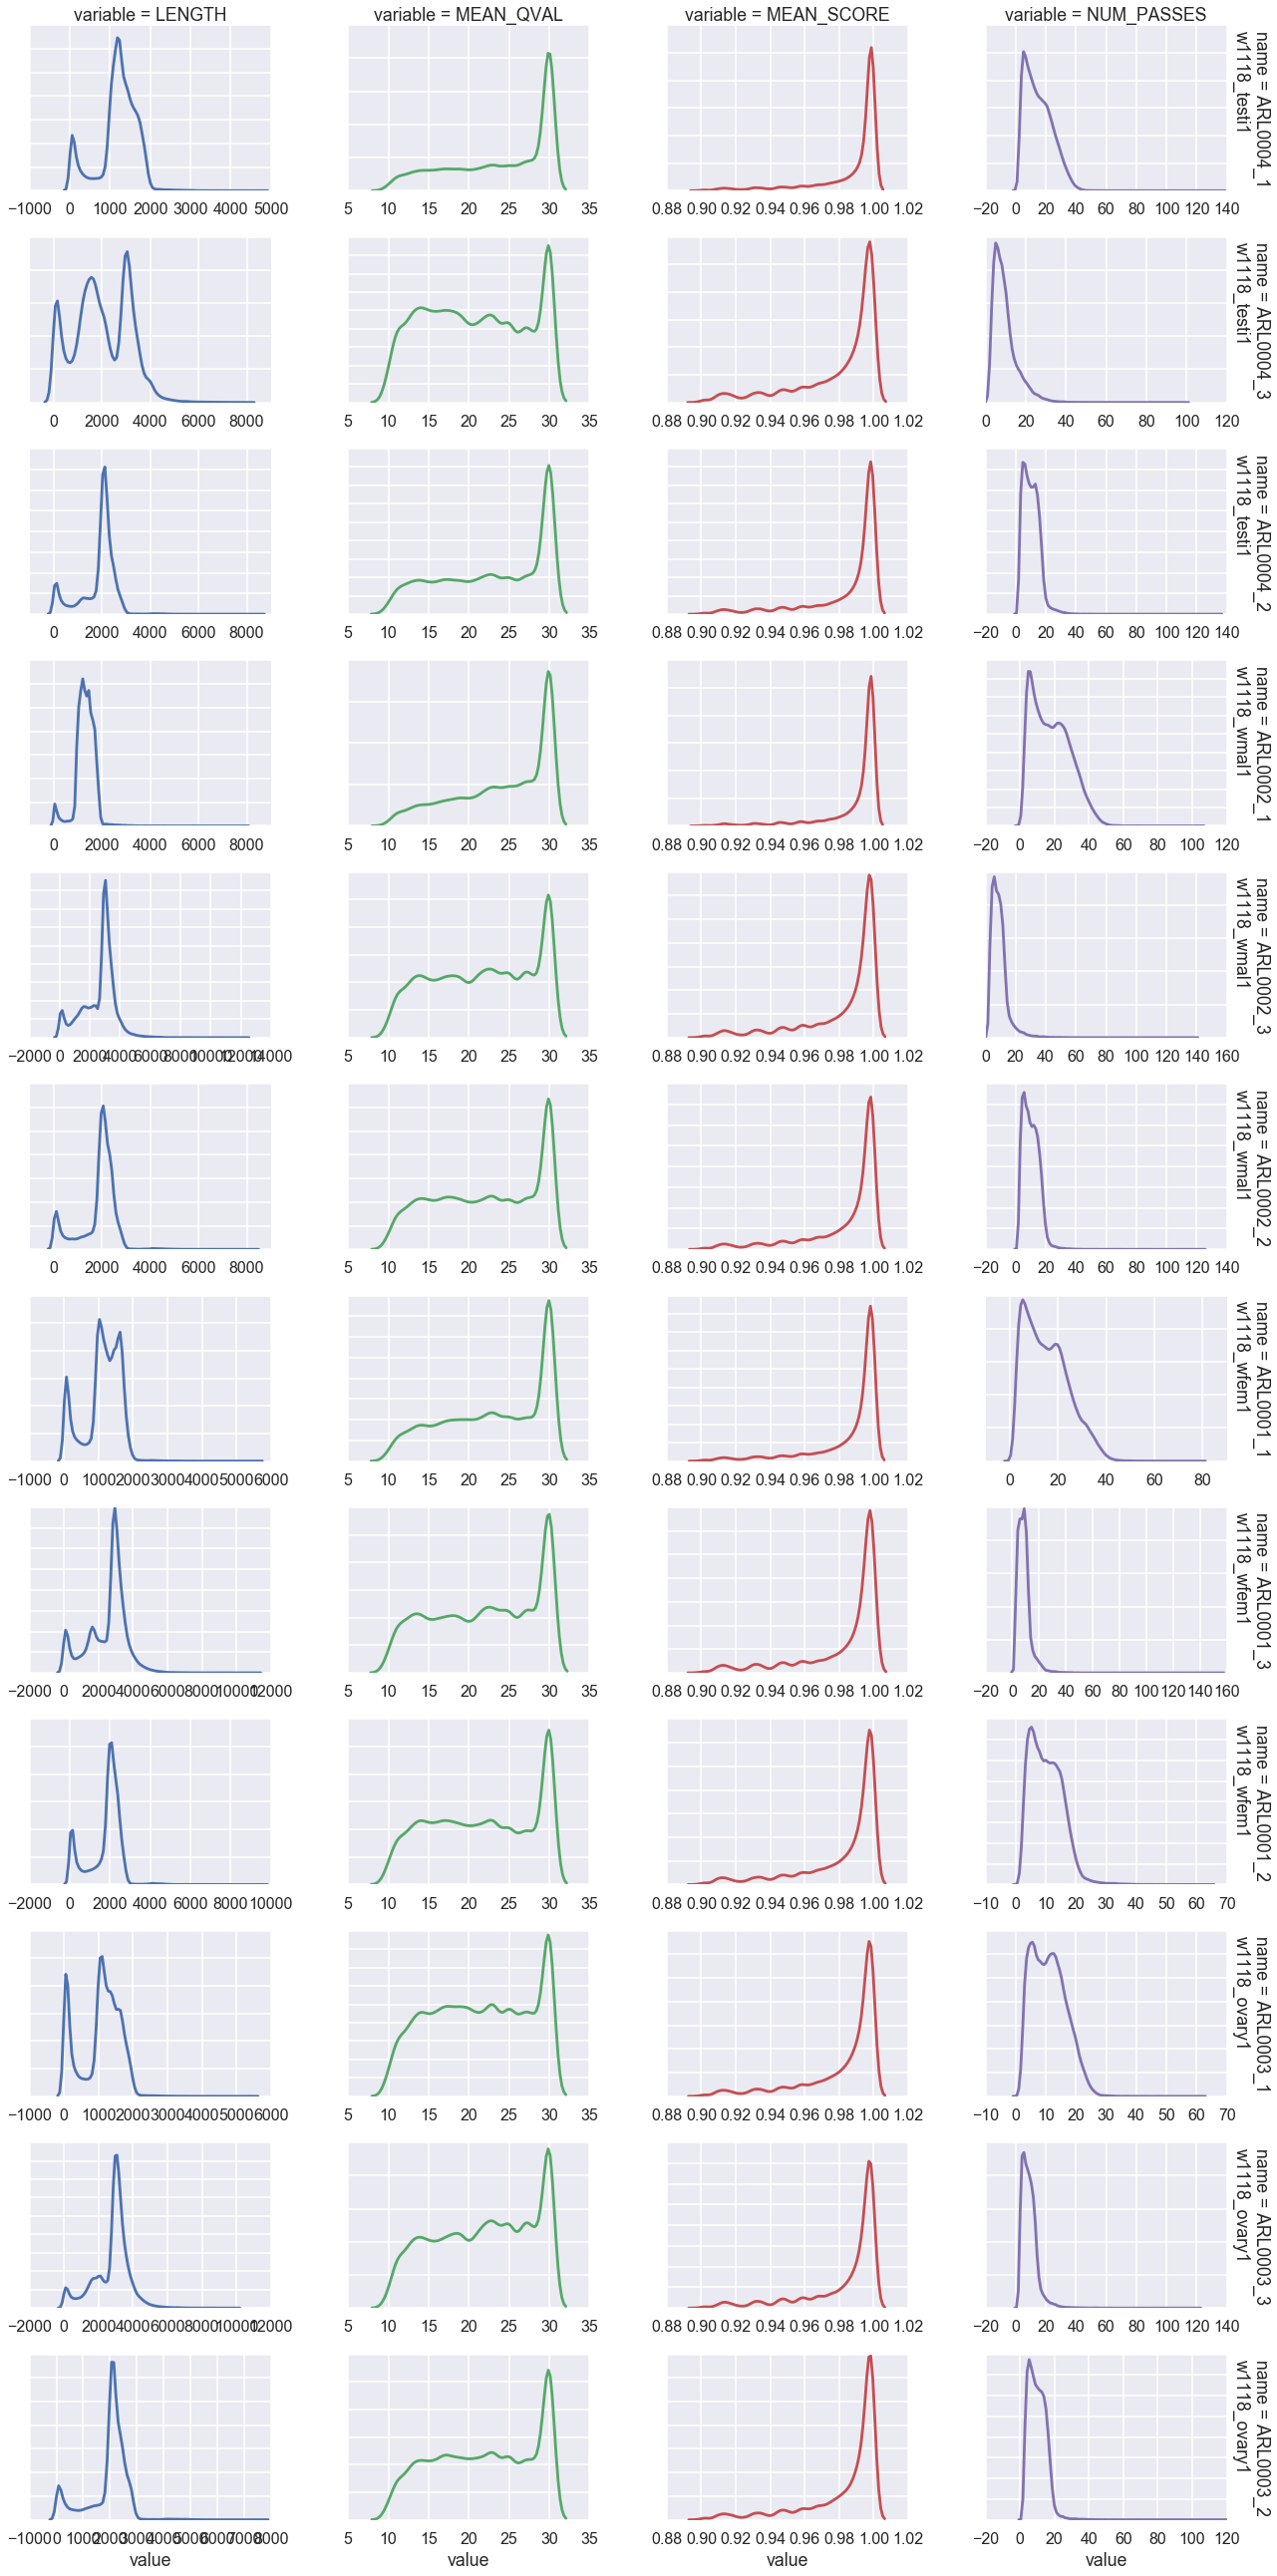

In [21]:
# Plot each column for the different samples/sizes
melted = pd.melt(dfRoi, id_vars=['name'], value_vars=['LENGTH', 'MEAN_QVAL', 'MEAN_SCORE', 'NUM_PASSES'])
g = sns.FacetGrid(melted, row='name', col='variable', hue='variable', sharex=False, sharey=False, size=3, aspect=1.5, margin_titles=True)
g = g.map(sns.kdeplot, "value")
g = g.set(yticklabels=[])

In [22]:
# Print Summary Stats of the Lengths
lenStack = dfRoi[['sampleID', 'sample', 'LENGTH']].groupby(['sampleID', 'sample']).describe(percentiles=[])
lengths = lenStack.unstack()
lengths.columns = lengths.columns.droplevel()
lengths

,,count,mean,std,min,50%,max
sampleID,sample,,,,,,
ARL0001_1,w1118_wfem1,48101.0,1115.515041,522.259578,13.0,1189.0,5571.0
ARL0001_2,w1118_wfem1,54615.0,1737.109146,825.231801,14.0,1997.0,9554.0
ARL0001_3,w1118_wfem1,47094.0,2513.541131,1134.530977,11.0,2858.0,11012.0
ARL0002_1,w1118_wmal1,43836.0,1305.718519,385.398935,14.0,1319.0,7947.0
ARL0002_2,w1118_wmal1,61698.0,1836.074541,760.037957,11.0,2037.0,8243.0
ARL0002_3,w1118_wmal1,57258.0,2610.490202,1099.473603,15.0,2937.0,12181.0
ARL0003_1,w1118_ovary1,54188.0,1042.448974,584.557949,13.0,1143.0,5427.0
ARL0003_2,w1118_ovary1,57143.0,1913.603433,767.995305,13.0,2107.0,7637.0
ARL0003_3,w1118_ovary1,54869.0,2777.669814,1037.904186,15.0,2992.0,9846.0


In [23]:
# Print the number of reads per sample
lengths.groupby(level=-1).sum()['count'].to_frame().applymap(lambda x: '{:,}'.format(int(x)))

,count
sample,
w1118_ovary1,"166,200"
w1118_testi1,"185,264"
w1118_wfem1,"149,810"
w1118_wmal1,"162,792"


## Exploring ccs2

In [24]:
# Import all of the data files
def readCcs2CSVs(fnames):
    dfs = []
    for fn in fnames:
        df = pd.read_csv(os.path.join(data_dir, '{0}/ccs2/{0}_ccs2_stats.txt'.format(fn)), sep='\t', index_col=0)
        df['sampleID'] = fn
        df['sample'] = sample_map_inverse[fn.split('_')[0]]
        df['name'] = df['sampleID'] + '\n' + df['sample']
        df['size_range'] = size_map[fn.split('_')[1]]
        dfs.append(df)
    return pd.concat(dfs, axis=0)

dfCcs = readCcs2CSVs(sampleNames)

# Column Names:
## ['LENGTH', 'NUM_PASSES', 'MEAN_SCORE', 'MEAN_QVAL', 'sampleID', 'sample', 'name', 'size_range']

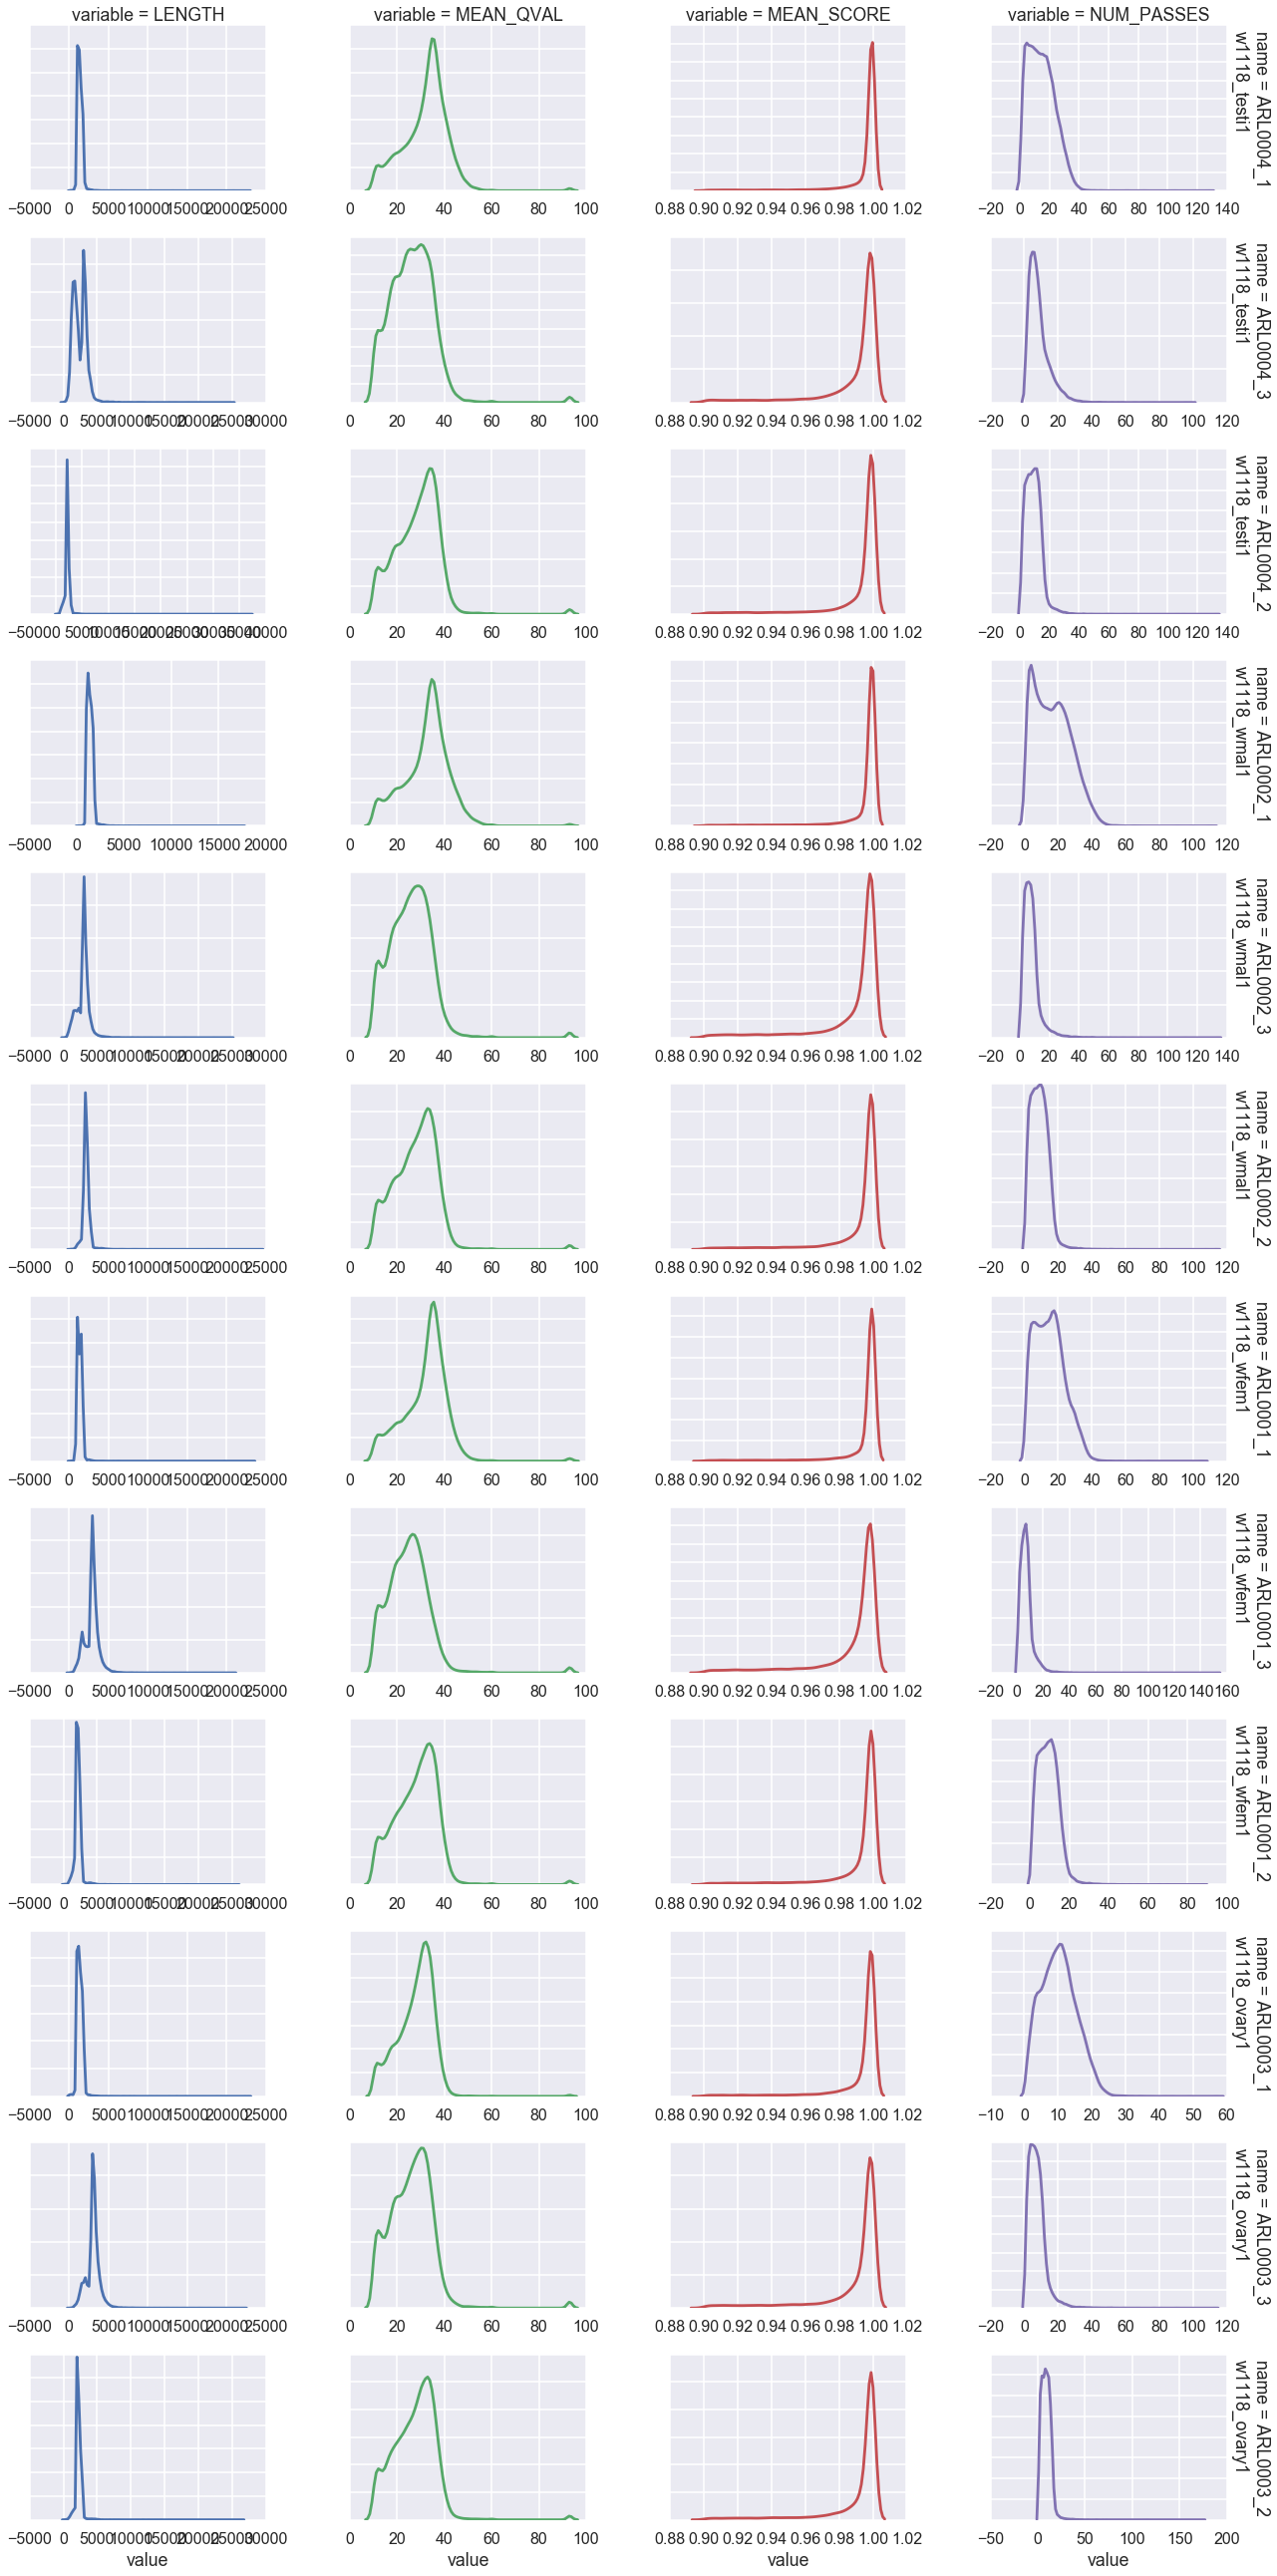

In [25]:
# Plot each column for the different samples/sizes
melted = pd.melt(dfCcs, id_vars=['name'], value_vars=['LENGTH', 'MEAN_QVAL', 'MEAN_SCORE', 'NUM_PASSES'])
g = sns.FacetGrid(melted, row='name', col='variable', hue='variable', sharex=False, sharey=False, size=3, aspect=1.5, margin_titles=True)
g = g.map(sns.kdeplot, "value")
g = g.set(yticklabels=[])

In [26]:
# Print Summary Stats of the Lengths
lenStack = dfCcs[['sampleID', 'sample', 'LENGTH']].groupby(['sampleID', 'sample']).describe(percentiles=[])
lengths2 = lenStack.unstack()
lengths2.columns = lengths2.columns.droplevel()
lengths2

,,count,mean,std,min,50%,max
sampleID,sample,,,,,,
ARL0001_1,w1118_wfem1,24506.0,1364.624051,368.074867,32.0,1350.0,23452.0
ARL0001_2,w1118_wfem1,28887.0,2175.293281,544.799983,20.0,2128.0,25843.0
ARL0001_3,w1118_wfem1,29919.0,2898.051439,904.189950,73.0,2960.0,20842.0
ARL0002_1,w1118_wmal1,35405.0,1389.732185,320.968281,44.0,1370.0,17636.0
ARL0002_2,w1118_wmal1,37193.0,2197.012637,520.127600,23.0,2135.0,24447.0
ARL0002_3,w1118_wmal1,37275.0,2937.450919,940.023393,80.0,3022.0,24816.0
ARL0003_1,w1118_ovary1,29992.0,1386.474527,509.323848,15.0,1335.0,22886.0
ARL0003_2,w1118_ovary1,33249.0,2263.254504,526.188279,44.0,2190.0,26553.0
ARL0003_3,w1118_ovary1,37981.0,3052.973724,876.312860,100.0,3082.0,22223.0


In [27]:
# Print the number of reads per sample
lengths2.groupby(level=-1).sum()['count'].to_frame().applymap(lambda x: '{:,}'.format(int(x)))

,count
sample,
w1118_ovary1,"101,222"
w1118_testi1,"107,807"
w1118_wfem1,"83,312"
w1118_wmal1,"109,873"


# Compare roi1 and ccs2

## Compare Number of Passes with Qualities

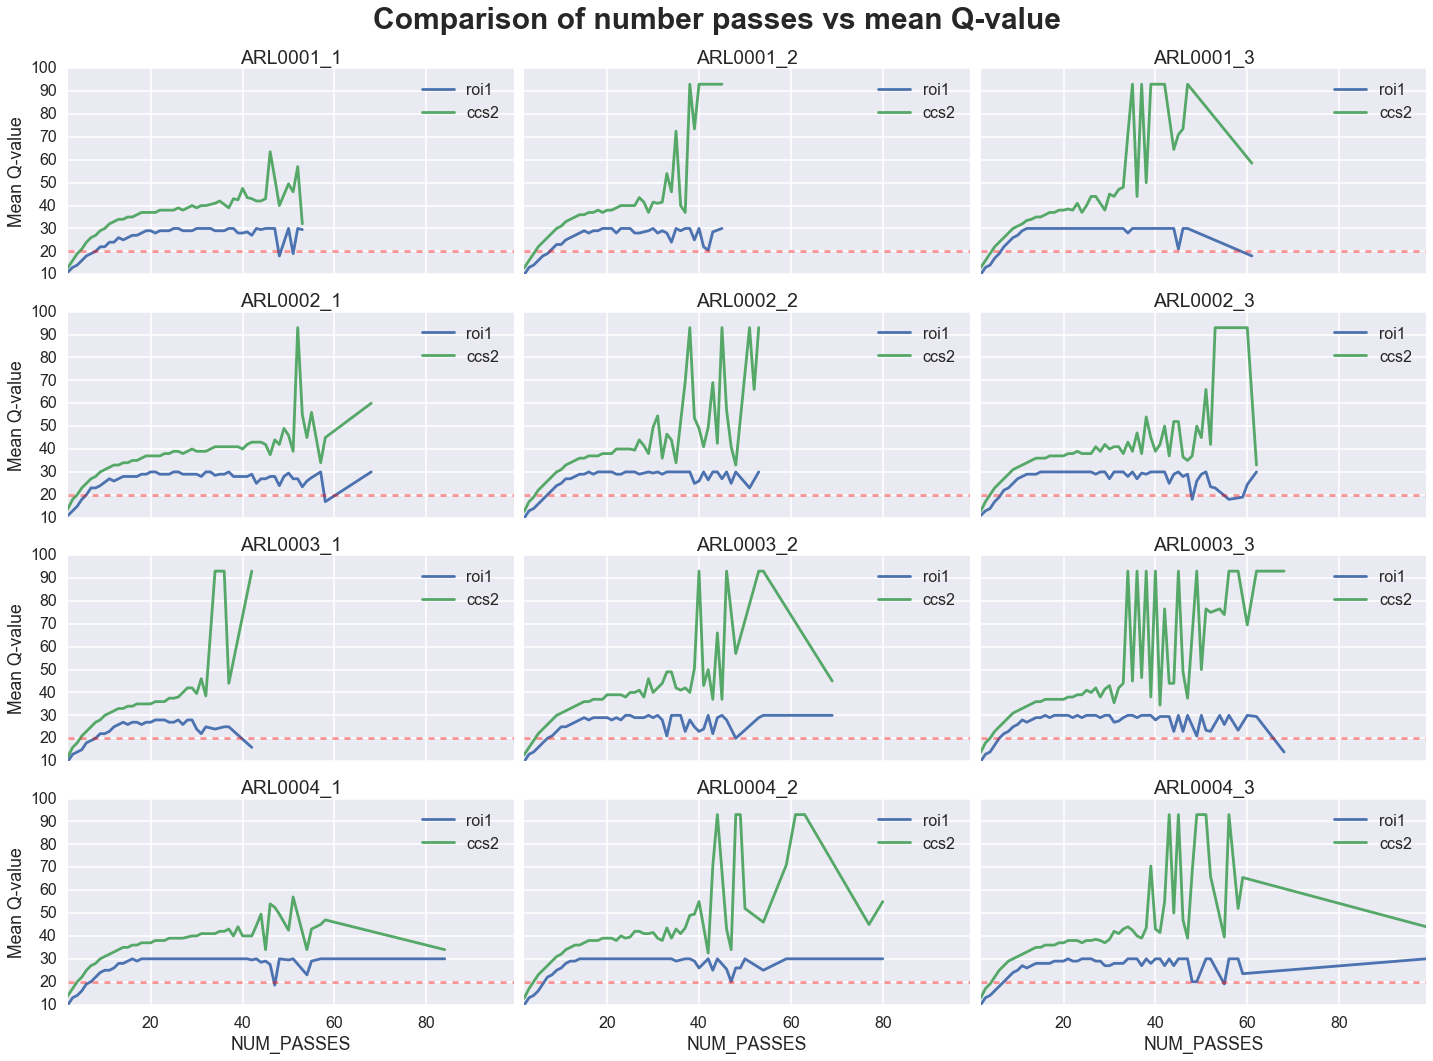

In [28]:
# Plot Number of Passes vs Mean Quality
fig, axes = plt.subplots(4, 3, figsize=(20, 15), sharex=True, sharey=True)
axes = np.ravel(axes)

for i, sample in enumerate(np.sort(dfRoi.sampleID.unique())):
    ax = axes[i]
    roi = dfRoi[dfRoi.sampleID == sample].groupby('NUM_PASSES').MEAN_QVAL.agg('median')
    roi.name = 'roi1'
    ccs = dfCcs[dfCcs.sampleID == sample].groupby('NUM_PASSES').MEAN_QVAL.agg('median')
    ccs.name = 'ccs2'
    dd = pd.concat([roi, ccs], axis=1)
    dd.dropna().plot(ax=ax)
    ax.set_title(sample)
    ax.set_ylabel('Mean Q-value')
    ax.axhline(20, ls='--', color='r', alpha=.4)

plt.suptitle('Comparison of number passes vs mean Q-value', fontsize=30, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

In [29]:
# Import roi1 read IDs
roi1 = set()
with gzip.open('/data/Oliverlab/fastq/PacBio/Data_20160630/ARL0001_1/roi1/reads_of_insert.fastq.gz', 'rb') as FH:
    for i, j in enumerate(FH.readlines()):
        if i % 4 == 0:
            roi1.add(j.decode('utf-8').strip())

In [30]:
# Import ccs2 read IDs
ccs2 = set()
with gzip.open('/data/Oliverlab/fastq/PacBio/Data_20160630/ARL0001_1/ccs2/m160606_202633_42231_c100988372550000001823222407191664_s1_p0.ccs.fastq.gz', 'rb') as FH:
    for i, j in enumerate(FH.readlines()):
        if i % 4 == 0:
            ccs2.add(j.decode('utf-8').strip())

In [31]:
# I stored readIDs in sets so I can just use set differences to figure out what the differences are.
roi1_not_ccs2 = roi1 - ccs2
ccs2_not_roi1 = ccs2 - roi1

# First lets look at read counts
print('roi1 has {0:,} more reads compared to ccs2'.format(len(roi1) - len(ccs2)))

# What extra reads does roi1 have
print('roi1 has {0:,} reads not in ccs2'.format(len(roi1 - ccs2)))

# What extra reads does ccs2 have
print('ccs2 has {0:,} reads not in roi1'.format(len(ccs2 - roi1)))

roi1 has 23,595 more reads compared to ccs2
roi1 has 23,932 reads not in ccs2
ccs2 has 337 reads not in roi1


# Reads with Poly-A

I am also not sure about the read processing with regards to the poly-A tail. How many reads in roi1 and ccs2 have poly-a tails?

In [32]:
# Basic functions to look for polyA
def hamming(x,y):
    """ Count the number of differences between two equal length strings.
    
    Parameters
    ----------
    x: str
        First string of length n
    y: str
        Second String of length n
    
    Retruns
    -------
    The number of differences between two strings.
    
    """
    assert len(x) == len(y)
    return sum(map(ne, x, y))

def findPolyA(s):
    """ Tries to find a polyA site using several criteria.
    
    First I look for the canonical polyA signal 'AAUAAA' and 
    then look downstream of that for multiple A allowing for 
    1 mismatch or N mismatchs where N is 10% of polyA length.
    
    If I cannot find a polyA signal, then I just look for 6 or 
    more A's at the end of the sequence allowing for 1 mismatch 
    or N mismatchs where N is 10% of polyA length.
    
    Parameters
    ----------
    s: str
        string of A's, C's, T's, or G's
    
    Returns
    -------
    Returns 1 if there is a polyA site and 0 if there is not one.
    
    """
    # Look for polyA site AAUAAA, then check to make sure it is followed by mostly A's
    # NOTE: I only need to look at the last one, so I can just use an empty loop
    try:
        for m in re.finditer('AATAAA', s):
            pass

        end = m.end()
        check = 'A' * len(s[end:])

        # The hamming distance must be less than 5% of the length
        if (hamming(s[end:], check) <= (.1 * len(check))) | (hamming(s[end:], check) <= 1):
            return 1
    except Exception:
        pass

    # If that does not work, then just look for polyA near the end
    try:
        for m in re.finditer('AAAAAA', s):
            pass

        start = m.start()
        check = 'A' * len(s[start:])

        # The hamming distance must be less than 10% of the length
        if (hamming(s[start:], check) <= (.1 * len(check))) | (hamming(s[start:], check) <= 1):
            return 1
    except:
        pass

    return 0

In [33]:
%%cache -s polyA_countsSubreads.pkl polyAcntsSubreads
# Import all of the data files
def readSubreadsFASTQs(fnames):
    counts = []
    # Iterate over all files
    for fn in fnames:
        # Simple counter
        cnts = {'polyA': 0, 'polyT': 0, 'polyA_reverse': 0, 'polyT_reverse': 0, 'read_count': 0}
        
        with gzip.open('../../data/Data_20160630/{0}/subreads/filtered_subreads.fastq.gz'.format(fn), 'rt', encoding='utf-8') as fh:
            # Iterate over each sequence
            for fq in SeqIO.parse(fh, 'fastq'):
                cnts['read_count'] +=1
                # I am not exactly sure about the direction or complementation. So I am going to try them all.
                for title, s in [('polyA', str(fq.seq)), ('polyA_reverse', str(fq.seq)[::-1]), 
                                 ('polyT', str(fq.seq.reverse_complement())), ('polyT_reverse', str(fq.seq.reverse_complement())[::-1])]:
                    cnts[title] += findPolyA(s)
                    
        # Make list of tuples with counts
        counts.append((fn, cnts['read_count'], cnts['polyA'], cnts['polyA_reverse'], cnts['polyT'], cnts['polyT_reverse']))
    
    # Return a DataFrame version
    return pd.DataFrame(counts, columns=['sampleID', 'read_count', 'polyA', 'polyA_reverse', 'polyT', 'polyT_reverse'])

polyAcntsSubreads = readSubreadsFASTQs(sampleNames)

In [34]:
%%cache -s polyA_countsRoi.pkl polyAcntsRoi
# Import all of the data files
def readRoi1FASTQs(fnames):
    counts = []
    # Iterate over all files
    for fn in fnames:
        # Simple counter
        cnts = {'polyA': 0, 'polyT': 0, 'polyA_reverse': 0, 'polyT_reverse': 0, 'read_count': 0}
        
        with gzip.open('../../data/Data_20160630/{0}/roi1/reads_of_insert.fastq.gz'.format(fn), 'rt', encoding='utf-8') as fh:
            # Iterate over each sequence
            for fq in SeqIO.parse(fh, 'fastq'):
                cnts['read_count'] +=1
                # I am not exactly sure about the direction or complementation. So I am going to try them all.
                for title, s in [('polyA', str(fq.seq)), ('polyA_reverse', str(fq.seq)[::-1]), 
                                 ('polyT', str(fq.seq.reverse_complement())), ('polyT_reverse', str(fq.seq.reverse_complement())[::-1])]:
                    cnts[title] += findPolyA(s)
                    
        # Make list of tuples with counts
        counts.append((fn, cnts['read_count'], cnts['polyA'], cnts['polyA_reverse'], cnts['polyT'], cnts['polyT_reverse']))
    
    # Return a DataFrame version
    return pd.DataFrame(counts, columns=['sampleID', 'read_count', 'polyA', 'polyA_reverse', 'polyT', 'polyT_reverse'])

polyAcntsRoi = readRoi1FASTQs(sampleNames)

In [35]:
%%cache -s polyA_countsCcs.pkl polyAcntsCcs
# Import all of the data files
def readCcsFASTQs(fnames):
    counts = []
    # Iterate over all files
    for fn in fnames:
        # Simple counter
        cnts = {'polyA': 0, 'polyT': 0, 'polyA_reverse': 0, 'polyT_reverse': 0, 'read_count': 0}
        
        with gzip.open(glob('../../data/Data_20160630/{0}/ccs2/*.fastq.gz'.format(fn))[0], 'rt', encoding='utf-8') as fh:
            # Iterate over each sequence
            for fq in SeqIO.parse(fh, 'fastq'):
                cnts['read_count'] +=1
                # I am not exactly sure about the direction or complementation. So I am going to try them all.
                for title, s in [('polyA', str(fq.seq)), ('polyA_reverse', str(fq.seq)[::-1]), 
                                 ('polyT', str(fq.seq.reverse_complement())), ('polyT_reverse', str(fq.seq.reverse_complement())[::-1])]:
                    cnts[title] += findPolyA(s)
                    
        # Make list of tuples with counts
        counts.append((fn, cnts['read_count'], cnts['polyA'], cnts['polyA_reverse'], cnts['polyT'], cnts['polyT_reverse']))
    
    # Return a DataFrame version
    return pd.DataFrame(counts, columns=['sampleID', 'read_count', 'polyA', 'polyA_reverse', 'polyT', 'polyT_reverse'])

polyAcntsCcs = readCcsFASTQs(sampleNames)

In [38]:
polyAcntsSubreads.sort_values('sampleID').set_index('sampleID')

,read_count,polyA,polyA_reverse,polyT,polyT_reverse
sampleID,,,,,
ARL0001_1,1059365,1335,1755,1549,2979
ARL0001_2,804436,1176,1359,1044,2184
ARL0001_3,568330,1171,1213,894,1601
ARL0002_1,892177,1059,1286,1140,1576
ARL0002_2,823582,1371,1635,1336,1981
ARL0002_3,679952,1291,1374,942,1759
ARL0003_1,886214,1540,2904,1849,3013
ARL0003_2,759571,1348,1569,1224,1722
ARL0003_3,636354,1248,1243,954,1525


polyAcntsRoi.sort_values('sampleID').set_index('sampleID')

In [37]:
polyAcntsCcs.sort_values('sampleID').set_index('sampleID')

,read_count,polyA,polyA_reverse,polyT,polyT_reverse
sampleID,,,,,
ARL0001_1,24506,8,10,13,7
ARL0001_2,28887,10,15,19,6
ARL0001_3,29919,18,21,24,12
ARL0002_1,35405,18,7,23,12
ARL0002_2,37193,18,20,16,17
ARL0002_3,37275,25,15,19,16
ARL0003_1,29992,31,17,45,3
ARL0003_2,33249,13,16,26,14
ARL0003_3,37981,15,14,30,17
